---
# **Machine Learning for Vision and Multimedia (01URPOV)**
---

### Authors:
*   Bramucci Roberto (s303683)
*   Paoli Leonardi Francesco (s297078)

The project focuses on the **_identification_** of the **_dynamical model_** of a **_physical system_**, in order to **_control_** it (by means of a suitable control law) and **_forecast its future behavior_** over time.

This is a fundamental problem in the **_automatic control and estimation_** field, which is tackled here by exploiting Deep Learning (DL) models, properly designed, with specific focus on **_recurrent and convolutional approaches_**.

<br>

All the project scripts and materials can be found in the following GitHub repository:

[https://github.com/franci1710/rnn_cnn_sysid](https://github.com/franci1710/rnn_cnn_sysid)

<br>

This Jupyter Notebook runs the scripts that have been developed for building, training and evalutating the performance of the DL models.

NOTE: for a proper code execution, the following four code cells must always be run.

In [ ]:
"""IMPORT NECESSARY LIBRARIES
Import all necessary Python libraries for:
- data loading, manipulation and analysis.
- models building, training and performance evaluation.
- general purpose utilities.
"""

# TensorFlow and Keras
from tensorflow import keras
from keras.regularizers import l2
from keras import activations, backend as K
from keras.utils import Sequence, custom_object_scope
from keras.models import Sequential, Model, load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Conv1D, Input, Concatenate, TimeDistributed, Flatten, Dropout, Add

# enable TensorBoard
%load_ext tensorboard

# Keras Temporal Convolutional Network (https://github.com/philipperemy/keras-tcn)
!pip install keras-tcn
from tcn import TCN

# data analysis and manipulation
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# tensor operations
import numpy as np

# data I/O utilities
import os
import csv
import requests
import scipy.io
from google.colab import drive

# general purpose utilities
import sys
import pytz
import pickle
from datetime import datetime
from IPython.display import Image, display


Clone the GitHub repository containing all the project's folders.

In [ ]:
"""CLONE PROJECT REPOSITORY
Clone the GitHub repository containing all project files, and import all Python modules contained in it.
If the repository has been already cloned in the past, it gets deleted and cloned again.
"""

# if the repository was already previously cloned, remove it
!rm -rf /content/rnn_cnn_sysid

# enter the Colab /content directory (where to clone the project)
%cd /content

# clone the repository in the /content directory
!git clone https://github.com/franci1710/rnn_cnn_sysid.git

# enter the source project directory
%cd /content/rnn_cnn_sysid

# import custom Python modules for building, training and testing the models to perform System Identification
from src import data_generator    as dg
from src import data_load_store   as dls
from src import data_process      as dp
from src import model_train_load  as mtl
from src import visualization     as vz
from src import metrics           as mt
from src import utilities         as ut


In [3]:
"""DEFINE PROJECT DATA PATHS
Definition of all useful paths inside the project's main folder '/content/rnn_cnn_sysid'
"""

# path to project's main folder
project_path = '/content/rnn_cnn_sysid'

# path to project's source code
src_path = project_path + '/src'

# path to project's dataset
data_path = project_path + '/data'

# paths to raw dataset for system identification
raw_data_path = data_path + '/raw'
raw_train_set_path = raw_data_path + '/train'
raw_valid_set_path = raw_data_path + '/validation'
raw_test_set_path  = raw_data_path + '/test'

# path to scalers fitted on train data
scalers_path = project_path + '/scalers'

# path to all NN models
models_path = project_path + '/models'

# path to trained NN models
tested_models_path = models_path + '/tested_models'

# paths to processed dataset for system identification
processed_data_path = data_path + '/processed'
processed_delta_data_path   = processed_data_path + '/delta_data'
processed_contig_data_path  = processed_data_path + '/contig_data'
processed_train_delta_set_path    = processed_delta_data_path   + '/train'
processed_valid_delta_set_path    = processed_delta_data_path   + '/validation'
processed_test_delta_set_path     = processed_delta_data_path   + '/test'
processed_train_contig_set_path   = processed_contig_data_path  + '/train'
processed_valid_contig_set_path   = processed_contig_data_path  + '/validation'
processed_test_contig_set_path    = processed_contig_data_path  + '/test'

# paths to final dataset for system identification
final_data_path = data_path + '/final'
final_delta_data_path   = final_data_path + '/delta_data'
final_contig_data_path  = final_data_path + '/contig_data'
final_train_delta_set_path  = final_delta_data_path   + '/train'
final_valid_delta_set_path  = final_delta_data_path   + '/validation'
final_test_delta_set_path   = final_delta_data_path   + '/test'
final_train_contig_set_path = final_contig_data_path  + '/train'
final_valid_contig_set_path = final_contig_data_path  + '/validation'
final_test_contig_set_path  = final_contig_data_path  + '/test'


In [4]:
"""DEFINE MODEL'S PURPOSE
Definition of the purpose of the model to be trained. There are two options:

1) control ==> the model will be trained on the 'delta' set

2) prediction ==> the model will be trained on the 'contiguous' set

"""

### TO BE SET MANUALLY ###
ask_model_purpose_to_user = 0     # if 1, ask the model purpose to the user through a GUI
model_purpose = 'control'         # manually set to 'control' or 'prediction' (in case 'ask_model_purpose_to_user == 0')

if (ask_model_purpose_to_user):
  # ask the user to insert the model's purpose: 'control' or 'prediction'
  model_purpose = ut.get_model_purpose()


---

# Section 1: **Dataset preprocessing**

---

This section contains the code to:


*   **Load the dataset** for performing system identification.
*   **Split and preprocess the dataset**, to obtain the final train, validation and test data.
*   **Store the preprocessed data** in the proper project folder, ready to be used for model training and making predictions on the system behavior.

NOTE: For users that are interested just to the training and prediction part, the preprocessed train, validation and test data have been already provided in the project folder, so that it is possible to directly start the execution from Section 2.

In [5]:
"""LOAD RAW DATASET
Load the raw train, validation and test datasets, where each sample is a time series containing real-time sampled values of:
- time [s]
- analog control signal sent to the yaw-motor of the robot [V]
- yaw position of the robot [deg]
- yaw velocity of the robot [deg/s]
"""

# load train, validation and test datasets, and get the number of samples for each of them
train_contig_set,  n_samples_train   = dls.load_dataset(raw_train_set_path)
valid_contig_set,  n_samples_valid   = dls.load_dataset(raw_valid_set_path)
test_contig_set,   n_samples_test    = dls.load_dataset(raw_test_set_path)

# get the length of each train, validation and test sample
train_samples_len = int(train_contig_set.shape[0]  / n_samples_train)
valid_samples_len = int(valid_contig_set.shape[0]  / n_samples_valid)
test_samples_len  = int(test_contig_set.shape[0]   / n_samples_test)

# dataset metadata
n_inputs  = 2     # input measurements:   time [seconds], analog control signal [voltage]
n_outputs = 2     # output measurements:  yaw position [degrees], yaw velocity [degrees/seconds]
n_sets    = 3     # datasets:             training, validation, testing

# general dataset info (e.g., number of samples, samples length, number of measured inputs, number of measured outputs)
dataset_info = [n_inputs, n_outputs, n_samples_train, n_samples_valid, n_samples_test, train_samples_len, valid_samples_len, test_samples_len]


In [6]:
"""SELECT DATASET SAMPLES TO BE VISUALIZED
From the raw dataset, here you can manually select some example samples and visualize them.
"""

# manually set the IDs of the dataset samples to be shown (one sample from each set)
id_train_sample_to_show = 0       # can be manually set in range [0,150]
id_valid_sample_to_show = 11      # can be manually set in range [0,14]
id_test_sample_to_show  = 14      # can be manually set in range [0,14]


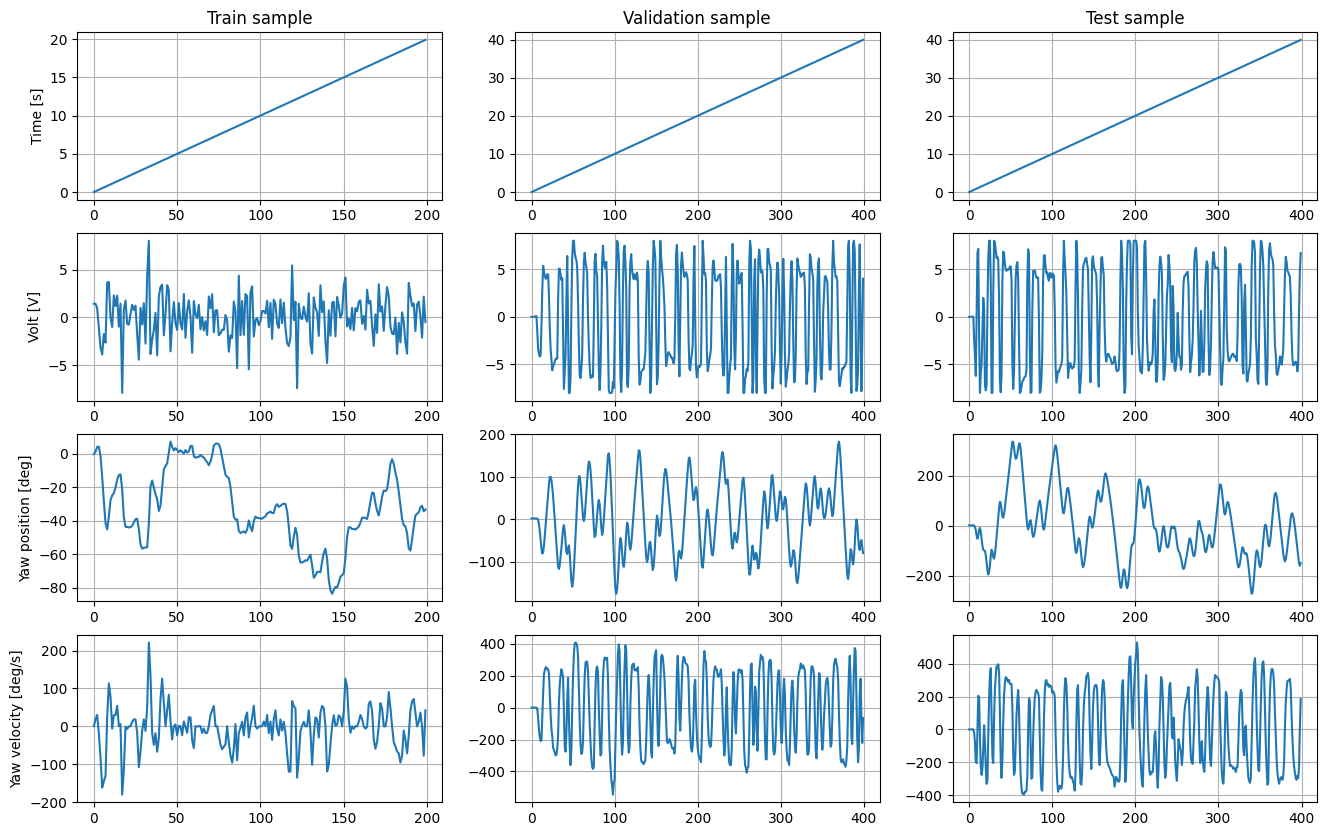

In [7]:
"""RAW DATASET VISUALIZATION
Visualize some exaples of raw experimentally-collected data.
"""

# show the above selected samples from train, validation and test sets
vz.show_dataset_samples(id_train_sample_to_show, id_valid_sample_to_show,  id_test_sample_to_show,
                        train_contig_set,        valid_contig_set,         test_contig_set,
                        train_samples_len,       valid_samples_len,        test_samples_len)


In [8]:
"""DATASET MANIPULATION
From an automatic control point of view, it is of interest for us to find the transfer function of the system, which means to predict
the variation (i.e., the "delta") of the gimbal's yaw position and velocity with respect to the control input given to the system.
Therefore, the dataset has to be manipulated in order to convert "absolute" yaw positions/velocities in "relative" ones, that in the following
are referred as "contiguous" and "delta" measurements, respectively.
"""

# transform 'contiguous' data in 'delta' data
train_delta_set = dp.contig_to_delta_meas(train_contig_set, n_samples_train,  train_samples_len)
valid_delta_set = dp.contig_to_delta_meas(valid_contig_set, n_samples_valid,  valid_samples_len)
test_delta_set  = dp.contig_to_delta_meas(test_contig_set,  n_samples_test,   test_samples_len)


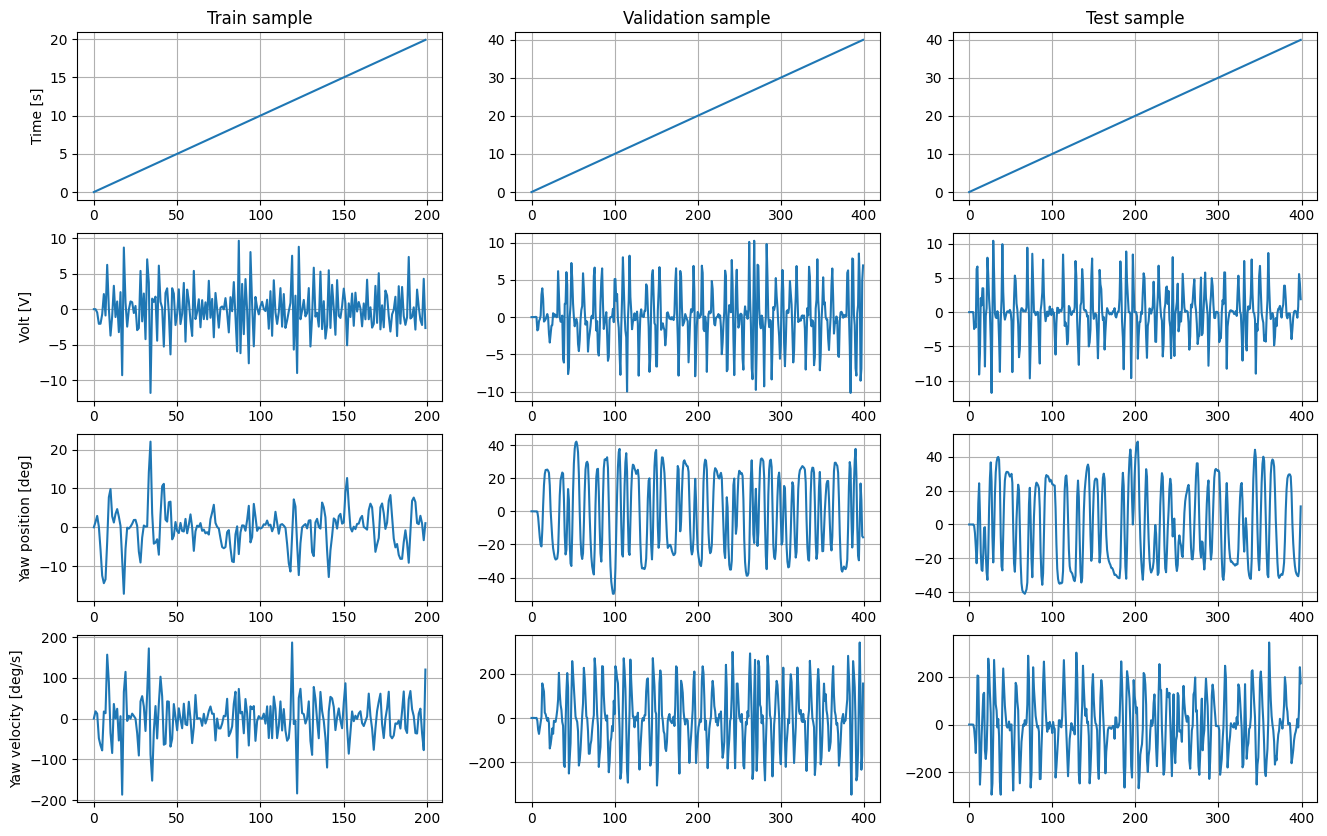

In [9]:
"""DELTA DATASET VISUALIZATION
Visualize some example samples from the 'delta' dataset (created by manipulating the 'contiguous' dataset).
"""

# show the above selected samples from train, validation and test sets
vz.show_dataset_samples(id_train_sample_to_show, id_valid_sample_to_show,  id_test_sample_to_show,
                        train_delta_set,         valid_delta_set,          test_delta_set,
                        train_samples_len,       valid_samples_len,        test_samples_len)


In [10]:
"""DATASET NORMALIZATION
The 'delta' and 'contiguous' datasets get normalized, in order to benefit the model training phase.
"""

# define the normalization range for each measured quantity
t_scale_bounds    = [ 0, 1]   # normalize time in range [0, 1]
u_scale_bounds    = [-1, 1]   # normalize control signal in range [-1, 1]
yaw_scale_bounds  = [-1, 1]   # normalize yaw position in range [-1, 1]
yawd_scale_bounds = [-1, 1]   # normalize yaw velocity in range [-1, 1]

# embed all normalization ranges into a list structure
scale_bounds = [t_scale_bounds, u_scale_bounds, yaw_scale_bounds, yawd_scale_bounds]

# fit all dataset scalers on the training data, so that the normalization of validation and testing data will have the same parameters as the training data normalization
delta_scalers = dp.fit_dataset_scalers(train_delta_set, scale_bounds)
contig_scalers = dp.fit_dataset_scalers(train_contig_set, scale_bounds)

# normalize the training, validation and testing data
train_delta_set_scaled  = dp.scale_dataset(train_delta_set, delta_scalers)
valid_delta_set_scaled  = dp.scale_dataset(valid_delta_set, delta_scalers)
test_delta_set_scaled   = dp.scale_dataset(test_delta_set,  delta_scalers)

train_contig_set_scaled = dp.scale_dataset(train_contig_set,  contig_scalers)
valid_contig_set_scaled = dp.scale_dataset(valid_contig_set,  contig_scalers)
test_contig_set_scaled  = dp.scale_dataset(test_contig_set,   contig_scalers)


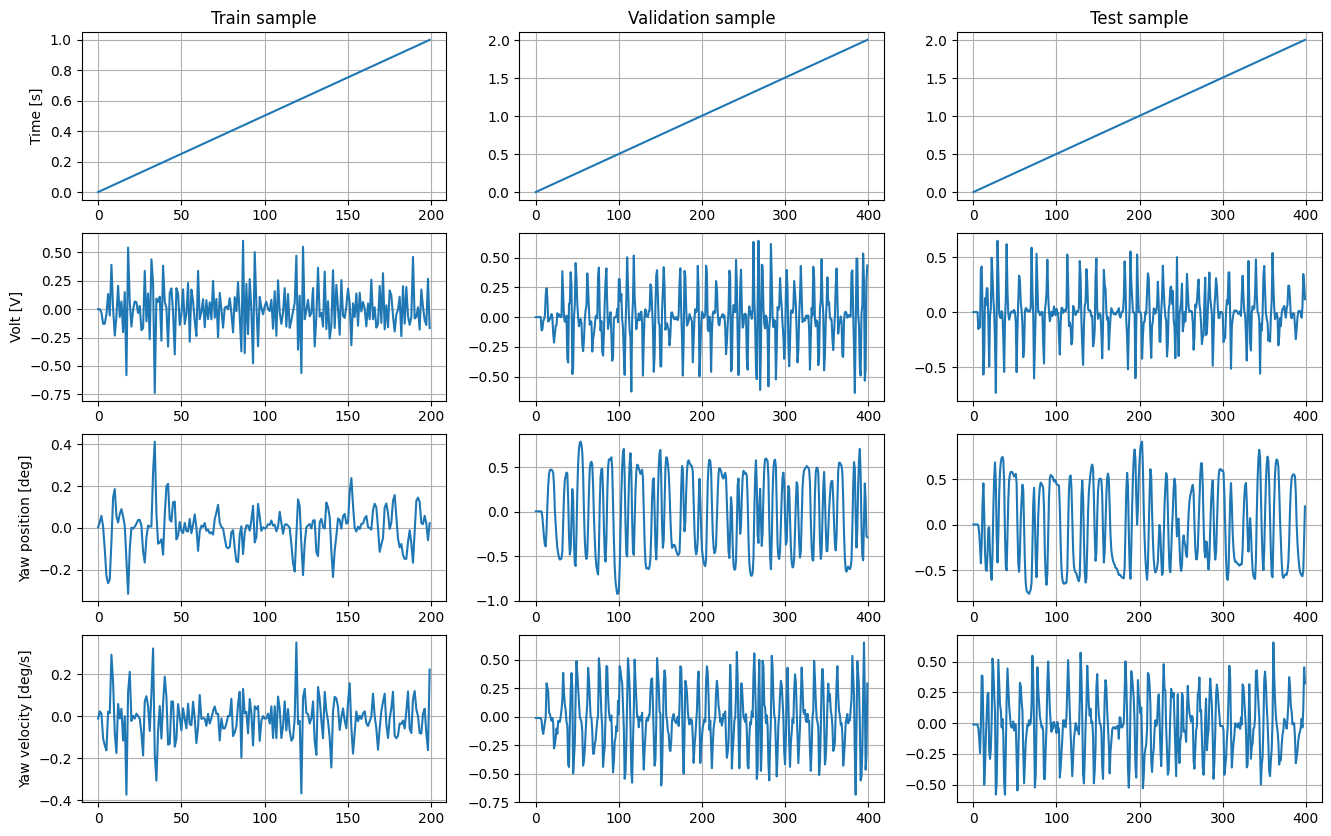

In [11]:
"""NORMALIZED CONTIGUOUS DATASET VISUALIZATION
Visualize some example samples from the normalized 'contiguous' dataset.
"""

# show the above selected samples from train, validation and test sets
vz.show_dataset_samples(id_train_sample_to_show, id_valid_sample_to_show,  id_test_sample_to_show,
                        train_delta_set_scaled,  valid_delta_set_scaled,   test_delta_set_scaled,
                        train_samples_len,       valid_samples_len,        test_samples_len)


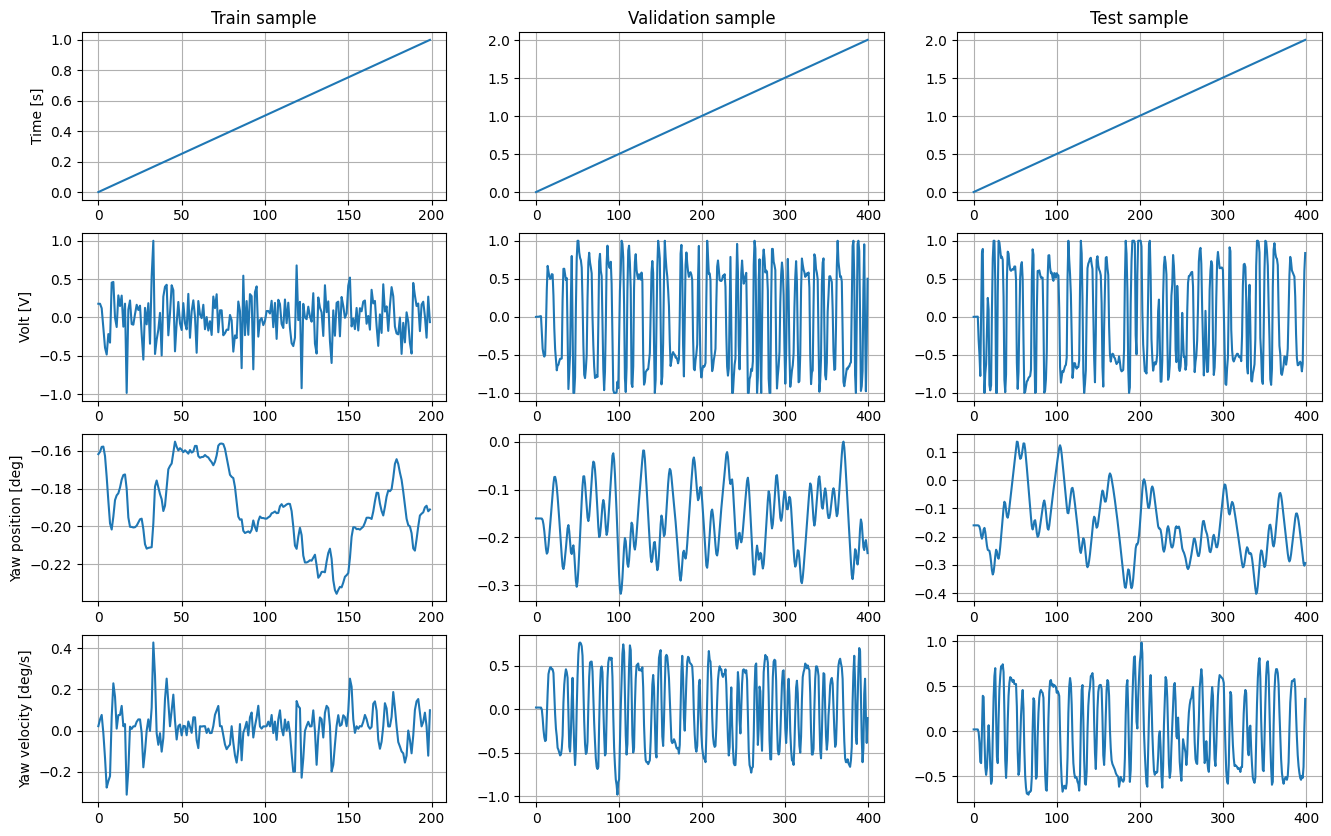

In [12]:
"""NORMALIZED DELTA DATASET VISUALIZATION
Visualize some example samples from the normalized 'delta' dataset.
"""

# show the above selected samples from train, validation and test sets
vz.show_dataset_samples(id_train_sample_to_show, id_valid_sample_to_show,  id_test_sample_to_show,
                        train_contig_set_scaled, valid_contig_set_scaled,  test_contig_set_scaled,
                        train_samples_len,       valid_samples_len,        test_samples_len)


In [13]:
"""FEATURES AND GROUND TRUTHS FOR MODEL TRAINING
From the processed train, validation and test datasets, extract the features and ground truths
to be used for model training and making predictions with it.
"""

#### DELTA DATASET ####
X_train_delta,  Y_train_delta = np.split(train_delta_set_scaled,  [n_inputs], axis=1)   # training data
X_valid_delta,  Y_valid_delta = np.split(valid_delta_set_scaled,  [n_inputs], axis=1)   # validation data
X_test_delta,   Y_test_delta  = np.split(test_delta_set_scaled,   [n_inputs], axis=1)   # testing data

#### CONTIGUOUS DATASET ####
X_train_contig,  Y_train_contig = np.split(train_contig_set_scaled,  [n_inputs], axis=1)    # training data
X_valid_contig,  Y_valid_contig = np.split(valid_contig_set_scaled,  [n_inputs], axis=1)    # validation data
X_test_contig,   Y_test_contig  = np.split(test_contig_set_scaled,   [n_inputs], axis=1)    # testing data


In [14]:
"""STORE DATASET INFO
Store the dataset info regarding:
- number of measured inputs in the dataset.
- number of measured outputs in the dataset.
- number of train, validation and test samples.
- train, validation and test samples length.
"""

# store dataset info
dataset_info_path = data_path + '/dataset_info.pkl'
pickle.dump(dataset_info, open(dataset_info_path, 'wb'))


In [15]:
"""STORE FITTED SCALERS
Store the scalers that have been fitted on the training data,
so that they can be used in the prediction stage to transform the model predictions back to the original scale. 
"""

# store the scalers previously fitted on train data
delta_scalers_path  = scalers_path + '/delta_scalers.pkl'
contig_scalers_path = scalers_path + '/contig_scalers.pkl'

pickle.dump(delta_scalers,  open(delta_scalers_path,  'wb'))
pickle.dump(contig_scalers, open(contig_scalers_path, 'wb'))


In [16]:
"""STORE PROCESSED DATASET
After having obtained the processed dataset by manipulating and normalizing the original dataset, the former is stored in the proper project folder.
"""

# store the processed train, validation and test datasets
dls.store_dataset(processed_train_delta_set_path,  train_delta_set_scaled, train_samples_len)
dls.store_dataset(processed_valid_delta_set_path,  valid_delta_set_scaled, valid_samples_len)
dls.store_dataset(processed_test_delta_set_path,   test_delta_set_scaled,  test_samples_len)

dls.store_dataset(processed_train_contig_set_path, train_contig_set_scaled, train_samples_len)
dls.store_dataset(processed_valid_contig_set_path, valid_contig_set_scaled, valid_samples_len)
dls.store_dataset(processed_test_contig_set_path,  test_contig_set_scaled,  test_samples_len)


In [17]:
"""STORE FINAL DATASET
Store the features and ground truths (of train, validation and test sets) in the proper project folder,
to be used during the model training and prediction phases.
"""

#### DELTA DATASET ####
# train set
np.savetxt(final_train_delta_set_path + '/X_train.csv', X_train_delta,  delimiter=',')      # train features of delta dataset
np.savetxt(final_train_delta_set_path + '/Y_train.csv', Y_train_delta,  delimiter=',')      # train ground truths of delta dataset
# validation set
np.savetxt(final_valid_delta_set_path + '/X_valid.csv', X_valid_delta,  delimiter=',')      # validation features of delta dataset
np.savetxt(final_valid_delta_set_path + '/Y_valid.csv', Y_valid_delta,  delimiter=',')      # validation ground truths of delta dataset
# test set
np.savetxt(final_test_delta_set_path  + '/X_test.csv',  X_test_delta,   delimiter=',')      # test features of delta dataset
np.savetxt(final_test_delta_set_path  + '/Y_test.csv',  Y_test_delta,   delimiter=',')      # test ground truths of delta dataset

#### CONTIGUOUS DATASET ####
# train set
np.savetxt(final_train_contig_set_path  + '/X_train.csv', X_train_contig,  delimiter=',')   # train features of contiguous dataset
np.savetxt(final_train_contig_set_path  + '/Y_train.csv', Y_train_contig,  delimiter=',')   # train ground truths of contiguous dataset
# validation set
np.savetxt(final_valid_contig_set_path  + '/X_valid.csv', X_valid_contig,  delimiter=',')   # validation features of contiguous dataset
np.savetxt(final_valid_contig_set_path  + '/Y_valid.csv', Y_valid_contig,  delimiter=',')   # validation ground truths of contiguous dataset
# test set
np.savetxt(final_test_contig_set_path   + '/X_test.csv',  X_test_contig,   delimiter=',')   # test features of contiguous dataset
np.savetxt(final_test_contig_set_path   + '/Y_test.csv',  Y_test_contig,   delimiter=',')   # test ground truths of contiguous dataset



---

# Section 2: **Model design, training and performance evaluation**

---

This section contains the code to:


*   **_Load the dataset_** previously preprocessed in the above section.
*   Define the **_DL model architecture_** for the prediction of the physical system behavior.
*   Define the **_metrics_** for model's predictions evaluation.
*   **_Train the model_** on the preprocessed dataset.

NOTE: If needed, all preprocessed data are already provided in the project's folder, hence it is possible to execute directly this section, skipping the previous one. Alternatively, preprocessed data for the model training and prediction phases can be generated by executing the code of Section 1.

In [18]:
"""MODEL TRAINING AND PREDICTIONS SETUP
Here you define what Section 2 should do (train a new model or load an already trained one),
and eventually set the training hyperparameters or select the already trained model to be loaded.

Main flags to be set:

use_already_trained_model
- if 0 ==> train a new model.
- if 1 ==> use an already trained model (stored in the /models project's folder).

search_best_lr
- if 0 ==> just execute the training and prediction phases.
- if 1 ==> before the training/prediction phases, use the LearningRateScheduler callback to choose the optimal LR value.

show_tensorboard
- if 0 ==> ignore the TensorBoard callback.
- if 1 ==> show the TensorBoard logs of the trained/loaded model.
"""


### MAIN FLAGS TO BE MANUALLY SET ###
use_already_trained_model = 1   # if 0, train a new model, otherwise load it from the project's folder.
search_best_lr = 0              # if 1, perform the LR-search through the LearningRateScheduler callback.
show_tensorboard = 0            # if 1, show the TensorBoard logs.


### TO BE TUNED IF 'use_already_trained_model == 0' ###

# hyperparameters for LR search (to be tuned manually)
n_epochs_lr_search = 50   # number of epochs of the LR search
lr_base_coeff = 1e-8      # base coefficient of the LR exponential grouth
lr_exp_coeff = 1/6        # exponent coefficient of the LR exponential grouth

# hyperparameters for model training (to be tuned manually)
id_model = '4'
window_size = 40    # number of timesteps of which a single model input time-window consists of
batch_size  = 32    # batch size
lr = 1e-4           # learning rate (LR)
n_epochs = 30       # number of training epochs

# hyperparameters for training callbacks
reduce_lr_factor    = 0.5   # ReduceLROnPlateau:  reduce factor
reduce_lr_patience  = 1     # ReduceLROnPlateau:  patience
min_lr_reduction    = 1e-6  # ReduceLROnPlateau:  lower bound of LR
early_stop_patience = 10    # EarlyStopping:      patience


### TO BE TUNED IF 'use_already_trained_model == 1' ###

# paths to the (already trained) model to loaded
already_trained_model_checkpoints_path = models_path + '/tested_models/trained_on_delta_data/model_03'    # path to the model's checkpoints folder
already_trained_model_path = already_trained_model_checkpoints_path + '/best_model.h5'                    # path to the model
already_trained_model_history_path = already_trained_model_checkpoints_path + '/train_history.pkl'        # path to the model's training history


In [19]:
"""LOAD DATASET INFO
Load the dataset info regarding:
- number of measured inputs in the dataset
- number of measured outputs in the dataset
- number of train, validation and test samples
- train, validation and test samples length
"""

# load dataset info
dataset_info_path = data_path + '/dataset_info.pkl'
dataset_info = pickle.load(open(dataset_info_path, 'rb'))

# extract all dataset info loaded from the binary file
[n_inputs, n_outputs, n_samples_train, n_samples_valid, n_samples_test, train_samples_len, valid_samples_len, test_samples_len] = dataset_info


In [20]:
"""LOAD FITTED SCALERS
Load the scalers that have been fitted on the training data,
so that they can be used in the prediction stage to transform the model predictions back to the original scale. 
"""

# load the scalers previously fitted on train data
delta_scalers_path  = scalers_path + '/delta_scalers.pkl'
contig_scalers_path = scalers_path + '/contig_scalers.pkl'

delta_scalers   = pickle.load(open(delta_scalers_path,  'rb'))
contig_scalers  = pickle.load(open(contig_scalers_path, 'rb'))

if (model_purpose == 'control'):
  scalers = delta_scalers
elif (model_purpose == 'prediction'):
  scalers = contig_scalers
else:
  print("Error: model purpose is not valid (it should be \'control\' or \'prediction\')")

In [21]:
"""GET PATH TO FEATURES AND GROUND TRUTHS
Depending on the model purpose ('control' or 'prediction'), select the features and ground truths
that will be used (the ones from 'delta' or 'contiguous' set, respectively). 
"""

# define the path for final data (depending on the model purpose)
if (model_purpose == 'control'):

  train_set_path = final_train_delta_set_path
  valid_set_path = final_valid_delta_set_path
  test_set_path  = final_test_delta_set_path

elif (model_purpose == 'prediction'):

  train_set_path = final_train_contig_set_path
  valid_set_path = final_valid_contig_set_path
  test_set_path  = final_test_contig_set_path

else:
  print("Error: model purpose is not valid (it should be \'control\' or \'prediction\')")


In [22]:
"""DATA GENERATORS FOR MODEL TRAINING, VALIDATION AND TESTING
Create the training, validation and testing data generators as instances of the
class SysIdentDataGenerator (implemented in /rnn_cnn_sysid/src/data_generator.py),
such that they can be used to train the model, validate it and perform prediction with it.
"""

if (not use_already_trained_model):
  
  # training data generator
  training_generator = dg.SysIdentDataGenerator(train_set_path + '/X_train.csv', train_set_path + '/Y_train.csv', n_samples_train,
                                                train_samples_len, window_size=window_size, batch_size=batch_size)
  # validation data generator
  validation_generator = dg.SysIdentDataGenerator(valid_set_path + '/X_valid.csv', valid_set_path + '/Y_valid.csv', n_samples_valid,
                                                  valid_samples_len, window_size=window_size, batch_size=batch_size)
# testing data generator
testing_generator = dg.SysIdentDataGenerator(test_set_path  + '/X_test.csv',  test_set_path  + '/Y_test.csv', n_samples_test,
                                             test_samples_len, window_size=window_size, batch_size=1, to_fit=False, shuffle=False)


In [23]:
"""BUILD/LOAD THE MODEL
- if 'use_already_trained_model == 0' ==> build a new model
- if 'use_already_trained_model == 1' ==> load an already trained model
"""

if (use_already_trained_model):

  # load an already trained model from the project's folder
  with custom_object_scope({'r_squared': mt.r_squared, 'TCN': TCN}):
    model, history = mtl.load_trained_model(already_trained_model_path, already_trained_model_history_path)

  # get the model's checkpoints path
  model_checkpoints_path = already_trained_model_checkpoints_path

else:

  # define the loss function and metrics for performance evaluation
  loss = 'mse'
  metrics = ['mse', 'mae', mt.r_squared]
  
  # build the model
  model = mtl.model_build(id_model, window_size, lr, loss, metrics)

  # get the model's checkpoints path
  model_checkpoints_path = ut.mkdir_model_checkpoints(models_path)

  # create a new folder to contain the model's checkpoints and logs
  !mkdir {model_checkpoints_path}


************************************
*                                  *
*    MODEL ARCHITECTURE SUMMARY    *
*                                  *
************************************

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 2)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,282
Trainable params: 17,282
Non-trainable params: 0
_________________________________________________________________


*********************************
*                               *
*    MODEL ARCHITECTURE PLOT    *
*                            

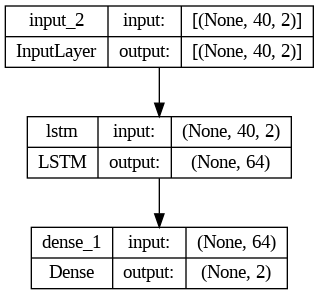

In [24]:
"""MODEL ARCHITECTURE
Visualization of the created/loaded model architecture.
"""

# visualize the model architecture
vz.show_model(model, model_checkpoints_path)


In [25]:
"""SEARCH FOR THE OPTIMAL LEARNING RATE
Use the LearningRateScheduler callback to explore various LR values, searching for the lowest (i.e., more "stable") value
that was leading to the fastest convergence time (to the minimum loss plateau).
"""

if (search_best_lr):

  # search LR
  history_lr_search = mtl.lr_search(model, training_generator, n_epochs_lr_search, validation_generator, lr_base_coeff, lr_exp_coeff, model_checkpoints_path)

  # visualize the loss curve over the tested LR values
  vz.show_lr_search(history_lr_search, n_epochs_lr_search, lr_base_coeff, lr_exp_coeff)

  if (not use_already_trained_model):
    # build again the model, so that it can be trained after the LR search
    model = mtl.model_build(id_model, window_size, lr, loss, metrics)


In [26]:
"""CALLBACKS
Definition of the training callbacks.
"""

# define the training callbacks
if (not use_already_trained_model):

  # reduce learning rate (LR) on plateau of training loss
  reduce_lr_on_plateau = ReduceLROnPlateau(monitor='loss', factor=reduce_lr_factor, patience=reduce_lr_patience, min_lr=min_lr_reduction, verbose=1, mode='min')

  # training early stopping
  early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience, verbose=1, mode='min')

  # model checkpoint
  model_checkpoint = ModelCheckpoint(filepath=model_checkpoints_path + '/epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5')

  # model training logs
  tensor_board = TensorBoard(log_dir=model_checkpoints_path + '/logs', histogram_freq=1)

  # stack the callbacks in a list
  callbacks=[reduce_lr_on_plateau, early_stop, model_checkpoint, tensor_board]
  

In [27]:
"""TRAIN THE MODEL
Start the training of the model previously built.
"""

if (not use_already_trained_model):

  # train the model and store the training histiry
  history = mtl.model_train(model, training_generator, validation_generator, n_epochs, callbacks, model_checkpoints_path)


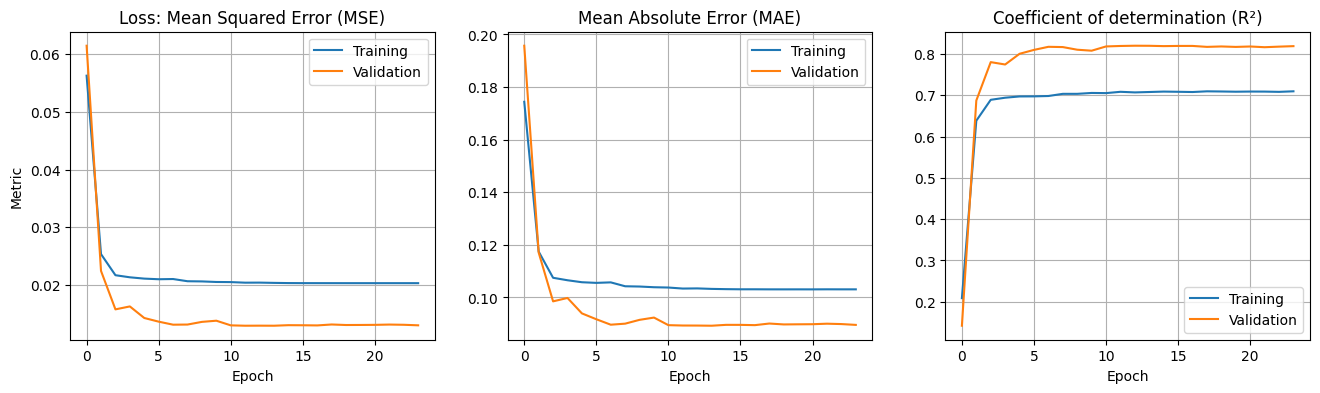

In [28]:
"""PLOT TRAINING AND VALIDATION METRICS OF THE MODEL
Plot the MSE, MAE and R^2 metrics of the trained/loaded model (for both training and validation data).
"""

# plot the MSE, MAE and R^2 metrics 
vz.plot_train_metrics(history)

In [29]:
"""VISUALIZE TENSORBOARD LOGS
Analyse the content of TensorBoard logs files (acquired during the model training).
"""

if (show_tensorboard):

  # show TensorBoard
  %tensorboard --logdir {model_checkpoints_path}/logs/train


In [30]:
"""GROUND TRUTHS FOR PREDICTIONS
Get the predictions' ground truths, and convert them back to their original scale.
"""

# get ground truths and de-normalize them
Y_test_true_scaled = np.loadtxt(test_set_path  + '/Y_test.csv', delimiter=',')
Y_test_true = dp.scale_dataset(Y_test_true_scaled,  scalers[n_inputs:],  inverse_transform=True)

if (model_purpose == 'control'):
  # get ground truths of the 'contiguous' set and de-normalize them
  Y_test_true_delta_to_contig_scaled = np.loadtxt(final_test_contig_set_path + '/Y_test.csv', delimiter=',')
  Y_test_true_delta_to_contig = dp.scale_dataset(Y_test_true_delta_to_contig_scaled, contig_scalers[n_inputs:], inverse_transform=True)


In [31]:
"""MAKE PREDICTIONS
Use the model to perform predictions on the 'delta' and/or 'contiguous' test sets.
"""

# use the model to make predictions
Y_test_pred_scaled = model.predict(testing_generator)
# de-normalize the predictions
Y_test_pred = dp.scale_dataset(Y_test_pred_scaled, scalers[n_inputs:], inverse_transform=True)

if (model_purpose == 'control'):
  # use model trained on 'delta' data to make predictions on the 'contiguous' test set 
  Y_test_pred_delta_to_contig, Y_test_true_delta_to_contig = dp.delta_to_contig_pred(Y_test_pred, Y_test_true, n_samples_test, test_samples_len, window_size)


5400/5400 [==============================] - 22s 4ms/step


In [32]:
"""SETUP THE PREDICTIONS VISUALIZATION
Manually setup the ID of the sample of which you want to see the prediction,
get the 'time' array of predictions and get the dataset name used to train the model.
"""

# ID of the sample of which you want to see the prediction (to be set manually)
id_pred_to_plot = 0   # can be manually set in range [0,14]

# get the 'time' array of predictions
X_test_true_scaled = np.loadtxt(test_set_path + '/X_test.csv', delimiter=',')
t_test = dp.scale_dataset(X_test_true_scaled[:,0], [scalers[0]], inverse_transform=True)

# get the dataset name used to train the model
if (model_purpose == 'control'):
  dataset_name = 'delta'
else:
  dataset_name = 'contiguous'

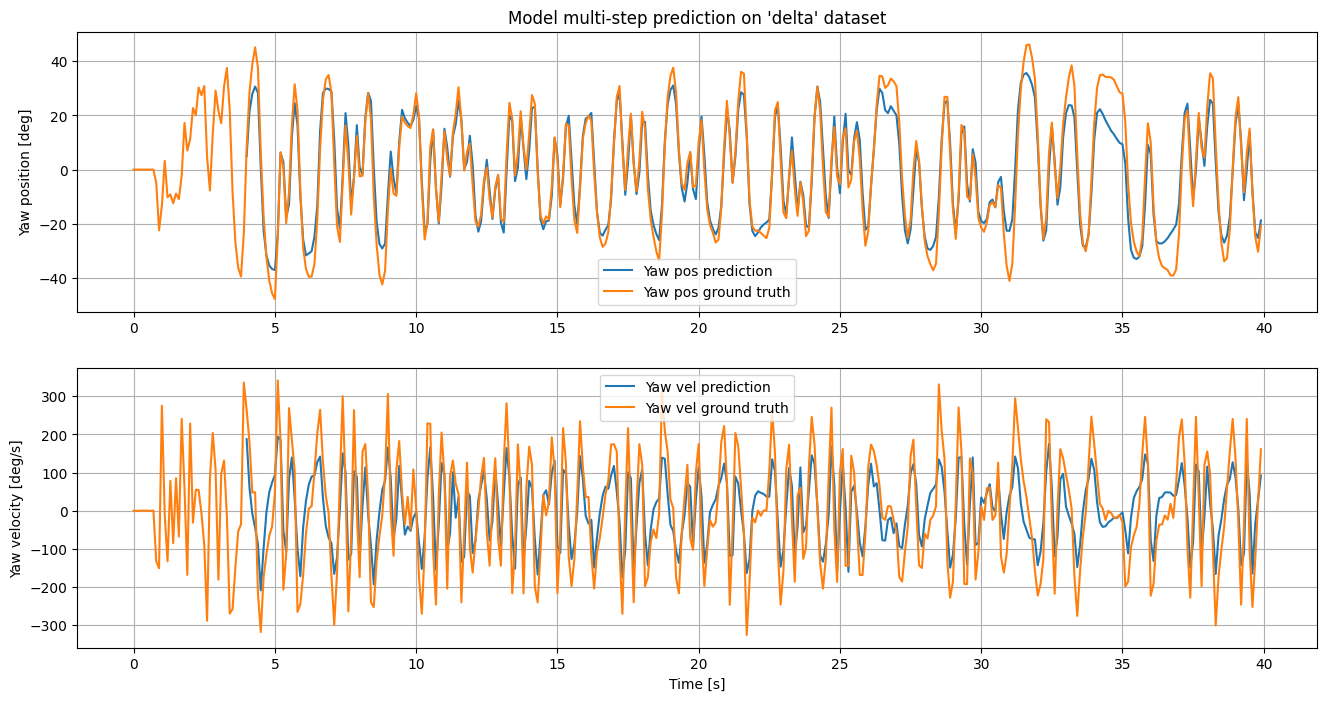

In [33]:
"""VISUALIZE PREDICTIONS
Visualize an example of sample predicted by the trained/loaded model (from the 'delta' or 'contiguous' set).
"""

# show the prediction
vz.plot_prediction(id_pred_to_plot, Y_test_pred, Y_test_true, t_test, test_samples_len, window_size, dataset_name)


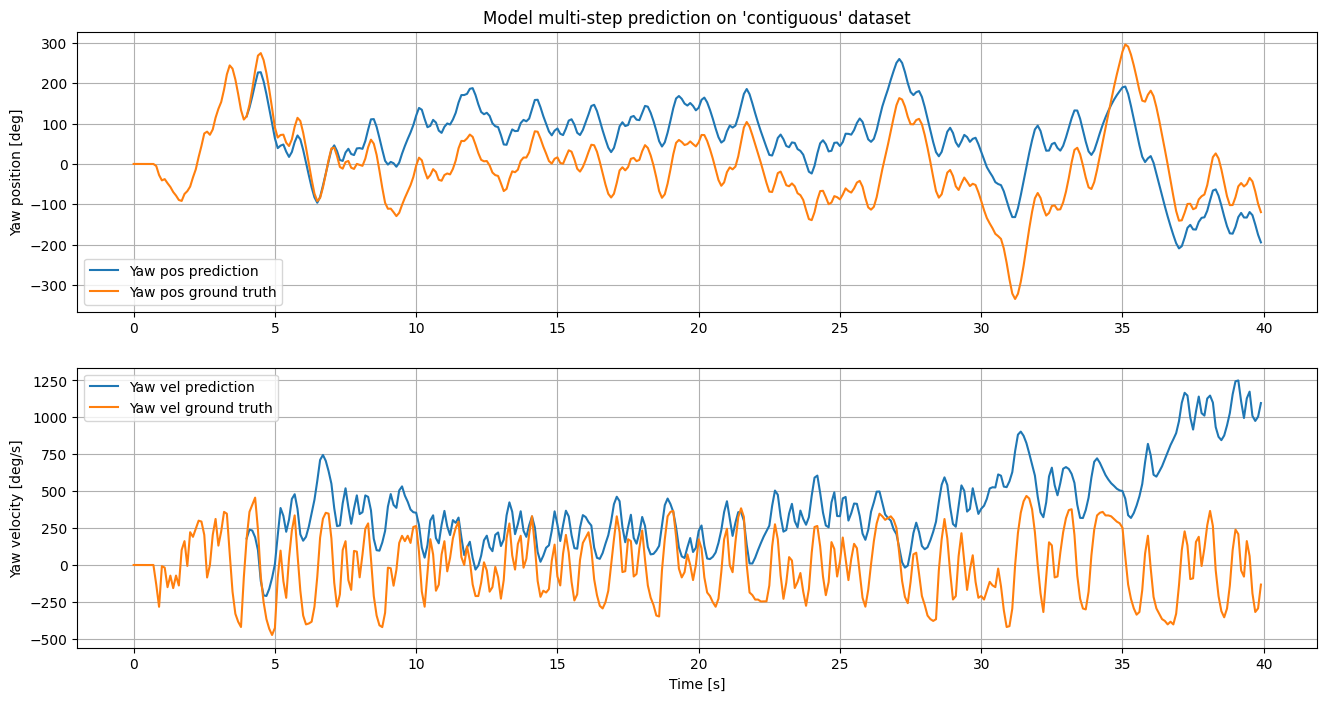

In [34]:
"""VISUALIZE PREDICTIONS ON CONTIGUOUS TEST SET
In case the model has been trained on the 'delta' set, then we use it also to try to
make predictions on the 'contiguous' set.
"""

if (model_purpose == 'control'):
  # show the prediction
  vz.plot_prediction(id_pred_to_plot, Y_test_pred_delta_to_contig, Y_test_true_delta_to_contig, t_test, test_samples_len, window_size, 'contiguous')

In [35]:
"""COMPUTE PREDICTIONS MSE
Compute the Mean Squared Error (MSE) of the predictions made by the trained/loaded model.
"""

# compute the MSE
mse = mt.mse_pred(Y_test_pred, Y_test_true, test_samples_len, window_size).reshape(-1,)
if (model_purpose == 'control'):
  mse_delta_to_contig = mt.mse_pred(Y_test_pred_delta_to_contig, Y_test_true_delta_to_contig, test_samples_len, window_size)
  mse = np.append(mse, mse_delta_to_contig[0])

# visualize the MSE
vz.show_mse_pred(model_purpose, mse)


MSE of yaw position on 'delta' data:       101.07793687459795
MSE of yaw velocity on 'delta' data:       1218.152349267207
MSE of yaw position on 'contiguous' data:  2318.5491820633833
MSE of yaw velocity on 'contiguous' data:  8024.639848006294
